In [1]:
import pandas as pd
df = pd.read_csv('mexico_city_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:57:48.995000,SAI,55,0 days 00:01:47.224000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:41.495000,...,True,Ferrari,0 days 00:56:01.523000,2024-10-27 20:03:34.674,124,2.0,False,NaN,False,False
1,0 days 01:00:06.932000,SAI,55,0 days 00:02:17.937000,2.0,1.0,NaN,NaN,0 days 00:01:01.514000,0 days 00:00:46.266000,...,True,Ferrari,0 days 00:57:48.995000,2024-10-27 20:05:22.146,4,2.0,False,NaN,False,False
2,0 days 01:02:20.703000,SAI,55,0 days 00:02:13.771000,3.0,1.0,NaN,NaN,0 days 00:00:56.743000,0 days 00:00:47.358000,...,True,Ferrari,0 days 01:00:06.932000,2024-10-27 20:07:40.083,4,2.0,False,NaN,False,False
3,0 days 01:04:30.746000,SAI,55,0 days 00:02:10.043000,4.0,1.0,NaN,NaN,0 days 00:00:52.782000,0 days 00:00:46.662000,...,True,Ferrari,0 days 01:02:20.703000,2024-10-27 20:09:53.854,4,2.0,False,NaN,False,False
4,0 days 01:06:40.671000,SAI,55,0 days 00:02:09.925000,5.0,1.0,NaN,NaN,0 days 00:00:53.462000,0 days 00:00:46.644000,...,True,Ferrari,0 days 01:04:30.746000,2024-10-27 20:12:03.897,4,2.0,False,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,0 days 01:18:35.223000,ALO,14,0 days 00:01:24.166000,13.0,1.0,NaN,NaN,0 days 00:00:29.336000,0 days 00:00:33.275000,...,False,Aston Martin,0 days 01:17:11.057000,2024-10-27 20:24:44.208,1,13.0,False,NaN,False,True
1211,0 days 01:19:59.589000,ALO,14,0 days 00:01:24.366000,14.0,1.0,NaN,NaN,0 days 00:00:29.526000,0 days 00:00:33.258000,...,False,Aston Martin,0 days 01:18:35.223000,2024-10-27 20:26:08.374,1,13.0,False,NaN,False,True
1212,0 days 01:21:28.010000,ALO,14,0 days 00:01:28.421000,15.0,1.0,NaN,0 days 01:21:25.485000,0 days 00:00:29.259000,0 days 00:00:33.443000,...,False,Aston Martin,0 days 01:19:59.589000,2024-10-27 20:27:32.740,1,17.0,False,NaN,False,False
1213,0 days 00:57:46.830000,ALB,23,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,True,Williams,0 days 00:56:01.523000,2024-10-27 20:03:34.674,124,NaN,False,NaN,True,False


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 71  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              0               0.0                1.0   
1    ALO              0               0.0               15.0   
2    BOT              1              50.0               35.0   
3    COL              1              48.0               35.0   
4    GAS              1              29.0               35.0   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0               0.0          1.000000         0.000000  
1               0.0          1.000000         0.000000  
2               0.0          0.300000         0.700000  
3               0.0          0.328571         0.671429  
4               0.0          0.400000         0.600000  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALO,15.0,0 days 01:21:25.485000,NaN,MEDIUM,16.0,1.0
1,BOT,49.0,0 days 02:08:43.389000,NaN,HARD,50.0,1.0
2,BOT,50.0,NaN,0 days 02:09:05.985000,MEDIUM,2.0,2.0
3,COL,47.0,0 days 02:05:49.833000,NaN,HARD,47.0,1.0
4,COL,48.0,NaN,0 days 02:06:13.782000,MEDIUM,1.0,2.0
5,GAS,28.0,0 days 01:39:23.394000,NaN,MEDIUM,28.0,1.0
6,GAS,29.0,NaN,0 days 01:39:46.672000,HARD,1.0,2.0
7,HAM,28.0,0 days 01:39:10.359000,NaN,MEDIUM,28.0,1.0
8,HAM,29.0,NaN,0 days 01:39:32.851000,HARD,1.0,2.0
9,HUL,29.0,0 days 01:40:43.158000,NaN,MEDIUM,29.0,1.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,0,0.0,1.000000,0.000000,1.000000,0.000000
1,ALO,0,0.0,15.000000,0.000000,1.000000,0.000000
2,BOT,1,50.0,35.000000,0.000000,0.300000,0.700000
3,COL,1,48.0,35.000000,0.000000,0.328571,0.671429
4,GAS,1,29.0,35.000000,0.000000,0.400000,0.600000
5,HAM,1,29.0,35.500000,0.000000,0.394366,0.605634
6,HUL,1,30.0,35.000000,0.000000,0.414286,0.585714
7,LAW,2,40.0,23.333333,0.071429,0.371429,0.557143
8,LEC,2,32.0,23.666667,0.028169,0.436620,0.535211
9,MAG,1,31.0,35.500000,0.000000,0.422535,0.577465


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,1061


In [9]:
df['Driver'].value_counts()


,count
Driver,
SAI,63
NOR,63
HAM,63
RUS,63
VER,63
MAG,63
PIA,63
HUL,62
GAS,62


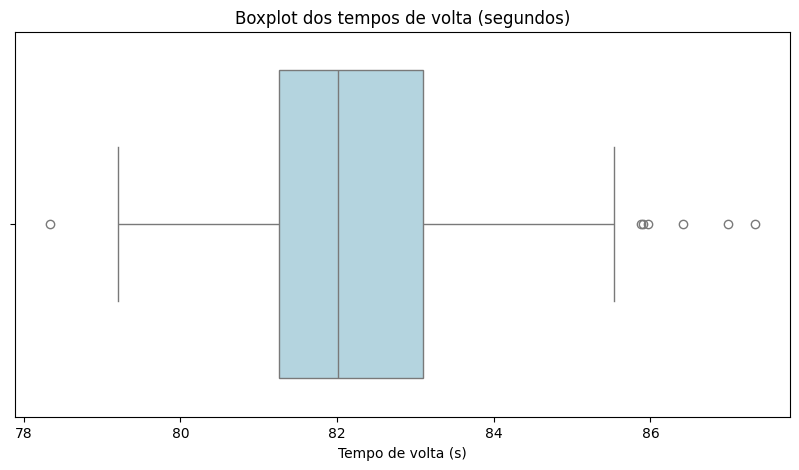

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


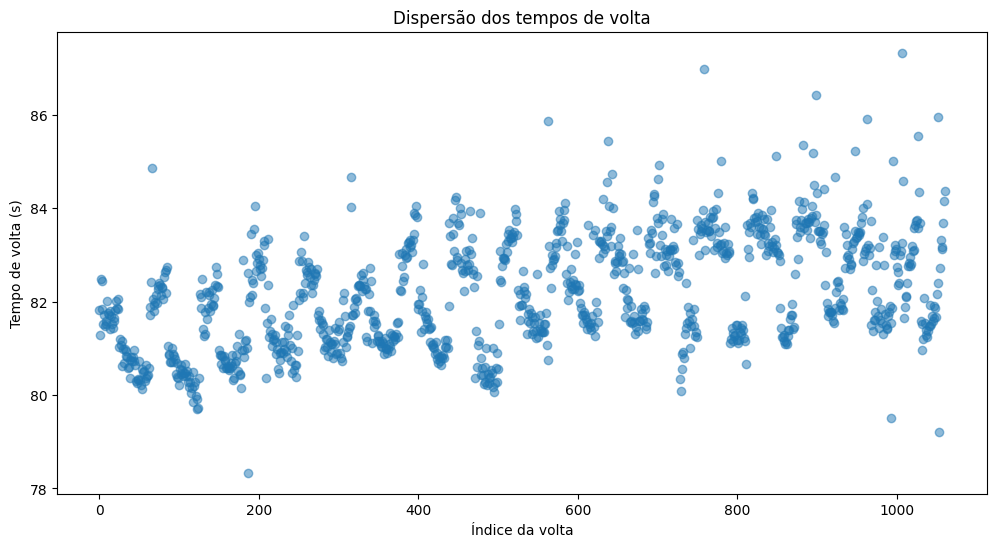

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


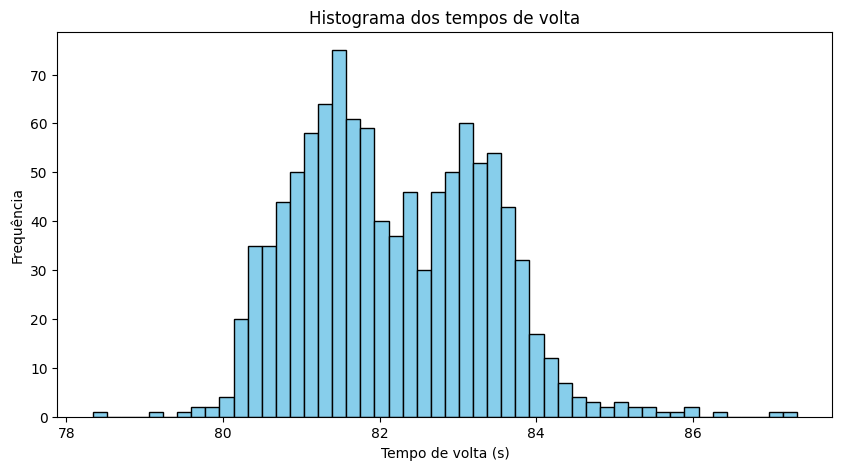

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


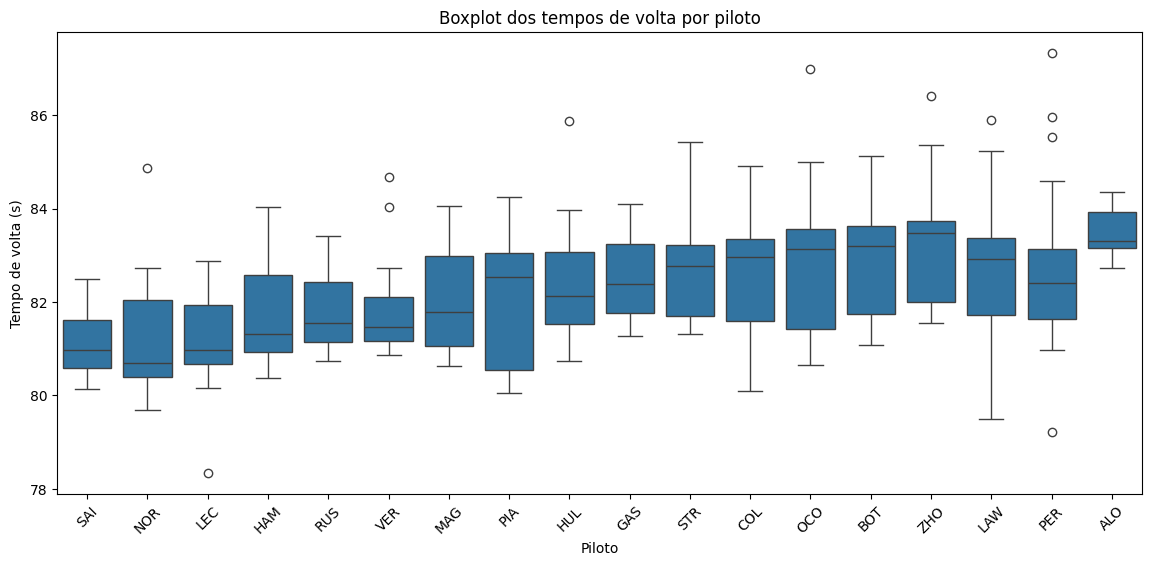

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
LEC   0 days 00:01:18.336000
PER   0 days 00:01:19.209000
LAW   0 days 00:01:19.502000
NOR   0 days 00:01:19.691000
PIA   0 days 00:01:20.064000
COL   0 days 00:01:20.090000
SAI   0 days 00:01:20.137000
HAM   0 days 00:01:20.371000
MAG   0 days 00:01:20.637000
OCO   0 days 00:01:20.659000
RUS   0 days 00:01:20.731000
HUL   0 days 00:01:20.748000
VER   0 days 00:01:20.872000
BOT   0 days 00:01:21.085000
GAS   0 days 00:01:21.274000
STR   0 days 00:01:21.311000
ZHO   0 days 00:01:21.553000
ALO   0 days 00:01:22.722000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Mexico'
race_date = '2024-10-27'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALO,7,83.507429,0.592856,82.722,84.366,83.3120,1.644,2024,Mexico,2024-10-27
1,BOT,62,82.895468,1.037340,81.085,85.121,83.1985,4.036,2024,Mexico,2024-10-27
2,COL,62,82.634290,1.121918,80.090,84.918,82.9730,4.828,2024,Mexico,2024-10-27
3,GAS,62,82.546306,0.809097,81.274,84.108,82.3855,2.834,2024,Mexico,2024-10-27
4,HAM,63,81.700698,0.962726,80.371,84.039,81.3080,3.668,2024,Mexico,2024-10-27
5,HUL,62,82.321419,0.970167,80.748,85.874,82.1220,5.126,2024,Mexico,2024-10-27
6,LAW,60,82.711217,1.104093,79.502,85.903,82.9280,6.401,2024,Mexico,2024-10-27
7,LEC,61,81.238754,0.821837,78.336,82.888,80.9750,4.552,2024,Mexico,2024-10-27
8,MAG,63,81.975397,1.010286,80.637,84.049,81.7790,3.412,2024,Mexico,2024-10-27
9,NOR,63,81.128508,1.026831,79.691,84.863,80.7030,5.172,2024,Mexico,2024-10-27


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALO,7,83.507429,0.592856,82.722,84.366,83.3120,1.644,2024,Mexico,2024-10-27,15.0,False
1,BOT,62,82.895468,1.037340,81.085,85.121,83.1985,4.036,2024,Mexico,2024-10-27,70.0,True
2,COL,62,82.634290,1.121918,80.090,84.918,82.9730,4.828,2024,Mexico,2024-10-27,70.0,True
3,GAS,62,82.546306,0.809097,81.274,84.108,82.3855,2.834,2024,Mexico,2024-10-27,70.0,True
4,HAM,63,81.700698,0.962726,80.371,84.039,81.3080,3.668,2024,Mexico,2024-10-27,71.0,True
5,HUL,62,82.321419,0.970167,80.748,85.874,82.1220,5.126,2024,Mexico,2024-10-27,70.0,True
6,LAW,60,82.711217,1.104093,79.502,85.903,82.9280,6.401,2024,Mexico,2024-10-27,70.0,True
7,LEC,61,81.238754,0.821837,78.336,82.888,80.9750,4.552,2024,Mexico,2024-10-27,71.0,True
8,MAG,63,81.975397,1.010286,80.637,84.049,81.7790,3.412,2024,Mexico,2024-10-27,71.0,True
9,NOR,63,81.128508,1.026831,79.691,84.863,80.7030,5.172,2024,Mexico,2024-10-27,71.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,0,0.0,1.000000,0.000000,1.000000,0.000000
1,ALO,0,0.0,15.000000,0.000000,1.000000,0.000000
2,BOT,1,50.0,35.000000,0.000000,0.300000,0.700000
3,COL,1,48.0,35.000000,0.000000,0.328571,0.671429
4,GAS,1,29.0,35.000000,0.000000,0.400000,0.600000
5,HAM,1,29.0,35.500000,0.000000,0.394366,0.605634
6,HUL,1,30.0,35.000000,0.000000,0.414286,0.585714
7,LAW,2,40.0,23.333333,0.071429,0.371429,0.557143
8,LEC,2,32.0,23.666667,0.028169,0.436620,0.535211
9,MAG,1,31.0,35.500000,0.000000,0.422535,0.577465


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALO,7,83.507429,0.592856,82.722,84.366,83.3120,1.644,2024,Mexico,2024-10-27,15.0,False,0,0.0,15.000000,0.000000,1.000000,0.000000
1,BOT,62,82.895468,1.037340,81.085,85.121,83.1985,4.036,2024,Mexico,2024-10-27,70.0,True,1,50.0,35.000000,0.000000,0.300000,0.700000
2,COL,62,82.634290,1.121918,80.090,84.918,82.9730,4.828,2024,Mexico,2024-10-27,70.0,True,1,48.0,35.000000,0.000000,0.328571,0.671429
3,GAS,62,82.546306,0.809097,81.274,84.108,82.3855,2.834,2024,Mexico,2024-10-27,70.0,True,1,29.0,35.000000,0.000000,0.400000,0.600000
4,HAM,63,81.700698,0.962726,80.371,84.039,81.3080,3.668,2024,Mexico,2024-10-27,71.0,True,1,29.0,35.500000,0.000000,0.394366,0.605634
5,HUL,62,82.321419,0.970167,80.748,85.874,82.1220,5.126,2024,Mexico,2024-10-27,70.0,True,1,30.0,35.000000,0.000000,0.414286,0.585714
6,LAW,60,82.711217,1.104093,79.502,85.903,82.9280,6.401,2024,Mexico,2024-10-27,70.0,True,2,40.0,23.333333,0.071429,0.371429,0.557143
7,LEC,61,81.238754,0.821837,78.336,82.888,80.9750,4.552,2024,Mexico,2024-10-27,71.0,True,2,32.0,23.666667,0.028169,0.436620,0.535211
8,MAG,63,81.975397,1.010286,80.637,84.049,81.7790,3.412,2024,Mexico,2024-10-27,71.0,True,1,31.0,35.500000,0.000000,0.422535,0.577465
9,NOR,63,81.128508,1.026831,79.691,84.863,80.7030,5.172,2024,Mexico,2024-10-27,71.0,True,1,31.0,35.500000,0.000000,0.422535,0.577465


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (18, 19)
Pilotos presentes: 18


In [23]:
df_completo.to_csv('df_completoMexico.csv', index=False)
